In [2]:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()


In [3]:
def load_user_csvs(folder_path, limit_users=3000):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])[:limit_users]
    item_id_map = {}
    item_counter = 1
    data = []

    for fname in files:
        try:
            path = os.path.join(folder_path, fname)
            df = pd.read_csv(path)
            df = df[df['action_type'] == 'respond']
            df = df.dropna(subset=['item_id', 'user_answer'])

            q_ids, corrects = [], []
            for _, row in df.iterrows():
                raw_q = row['item_id']
                if raw_q not in item_id_map:
                    item_id_map[raw_q] = item_counter
                    item_counter += 1
                q_ids.append(item_id_map[raw_q])
                corrects.append(np.random.randint(0, 2))  # Simulated correctness

            if len(q_ids) > 2:
                data.append({'q': q_ids, 'a': corrects})
        except:
            continue

    print(f"✅ Loaded {len(data)} valid users.")
    return data, item_counter


In [4]:
class KT_Dataset(Dataset):
    def __init__(self, data, max_seq=100):
        self.data = data
        self.max_seq = max_seq

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        q_seq = self.data[idx]['q'][-self.max_seq:]
        a_seq = self.data[idx]['a'][-self.max_seq:]
        seq_len = min(len(q_seq), len(a_seq))

        if seq_len < 3:
            return None

        q_seq = q_seq[:seq_len]
        a_seq = a_seq[:seq_len]

        input_seq = [q + a * 10000 for q, a in zip(q_seq, a_seq)]
        label_seq = a_seq[1:]
        input_seq = input_seq[:-1]

        return torch.LongTensor(input_seq), torch.FloatTensor(label_seq)

def pad_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)

    inputs, labels = zip(*batch)
    max_len = max(len(seq) for seq in inputs)

    padded_inputs = torch.stack([
        torch.cat([seq, torch.zeros(max_len - len(seq))]) for seq in inputs
    ])
    padded_labels = torch.stack([
        torch.cat([seq, torch.zeros(max_len - len(seq))]) for seq in labels
    ])

    return padded_inputs.long(), padded_labels.float()


In [5]:
class CNN_KT(nn.Module):
    def __init__(self, input_dim, embed_dim=128, num_filters=64, kernel_size=3):
        super(CNN_KT, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        embed = self.embedding(x)               # [batch, seq_len, embed_dim]
        embed = embed.transpose(1, 2)           # [batch, embed_dim, seq_len]
        conv_out = self.relu(self.conv1(embed)) # [batch, filters, seq_len]
        conv_out = conv_out.transpose(1, 2)     # [batch, seq_len, filters]
        pred = self.fc(self.dropout(conv_out)).squeeze(-1)  # [batch, seq_len]
        return pred


In [6]:
# @title
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for epoch in range(50):
        total_loss = 0
        count = 0
        for x, y in train_loader:
            if x.nelement() == 0: continue
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1
        print(f"Epoch {epoch+1}, Loss: {total_loss / max(count, 1):.4f}")

def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            if x.nelement() == 0: continue
            x, y = x.to(device), y.to(device)
            preds = torch.sigmoid(model(x)) > 0.5
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(y.cpu().numpy().flatten())

    print("\n📊 Evaluation Metrics:")
    print("Accuracy :", accuracy_score(all_labels, all_preds))
    print("Precision:", precision_score(all_labels, all_preds))
    print("Recall   :", recall_score(all_labels, all_preds))
    print("F1 Score :", f1_score(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


In [7]:
# @title
# Load dataset
data, input_dim = load_user_csvs("/content/drive/MyDrive/Project/dataset/KT", limit_users=10000)

# Train/test split
random.shuffle(data)
train_data = data[:int(0.8 * len(data))]
test_data = data[int(0.8 * len(data)):]

# Loaders
train_loader = DataLoader(KT_Dataset(train_data), batch_size=64, shuffle=True, collate_fn=pad_collate_fn)
test_loader = DataLoader(KT_Dataset(test_data), batch_size=64, collate_fn=pad_collate_fn)

# Model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_KT(input_dim=input_dim + 10000).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train & evaluate
train(model, train_loader, optimizer, criterion, device)
evaluate(model, test_loader, device)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim + 10000,
    'model_config': {
        'embed_dim': 128,
        'num_filters': 64,
        'kernel_size': 3
    },
    'training_info': {
        'dataset_size': len(data),
        'device': str(device)
    }
}, 'cnn_kt_trained_model.pth')
torch.save(model.state_dict(), 'cnn_model_weights.pth')
torch.save(model, 'cnn_full_model.pth')
traced_model = torch.jit.trace(model, torch.randn(1, 10, dtype=torch.long))
traced_model.save("cnn_model_torchscript.pt")


✅ Loaded 9675 valid users.
Epoch 1, Loss: 0.3738
Epoch 2, Loss: 0.2573
Epoch 3, Loss: 0.1420
Epoch 4, Loss: 0.0846
Epoch 5, Loss: 0.0589
Epoch 6, Loss: 0.0465
Epoch 7, Loss: 0.0400
Epoch 8, Loss: 0.0359
Epoch 9, Loss: 0.0332
Epoch 10, Loss: 0.0310
Epoch 11, Loss: 0.0295
Epoch 12, Loss: 0.0277
Epoch 13, Loss: 0.0262
Epoch 14, Loss: 0.0247
Epoch 15, Loss: 0.0232
Epoch 16, Loss: 0.0216
Epoch 17, Loss: 0.0204
Epoch 18, Loss: 0.0189
Epoch 19, Loss: 0.0178
Epoch 20, Loss: 0.0165
Epoch 21, Loss: 0.0153
Epoch 22, Loss: 0.0141
Epoch 23, Loss: 0.0133
Epoch 24, Loss: 0.0121
Epoch 25, Loss: 0.0114
Epoch 26, Loss: 0.0105
Epoch 27, Loss: 0.0096
Epoch 28, Loss: 0.0088
Epoch 29, Loss: 0.0082
Epoch 30, Loss: 0.0078
Epoch 31, Loss: 0.0072
Epoch 32, Loss: 0.0067
Epoch 33, Loss: 0.0065
Epoch 34, Loss: 0.0059
Epoch 35, Loss: 0.0055
Epoch 36, Loss: 0.0051
Epoch 37, Loss: 0.0049
Epoch 38, Loss: 0.0046
Epoch 39, Loss: 0.0045
Epoch 40, Loss: 0.0041
Epoch 41, Loss: 0.0040
Epoch 42, Loss: 0.0039
Epoch 43, Loss: 

NotImplementedError: "normal_kernel_cpu" not implemented for 'Long'

In [8]:
model = CNN_KT(input_dim=21552)
model.load_state_dict(torch.load('cnn_model_weights.pth'))
model.eval()

CNN_KT(
  (embedding): Embedding(21552, 128)
  (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

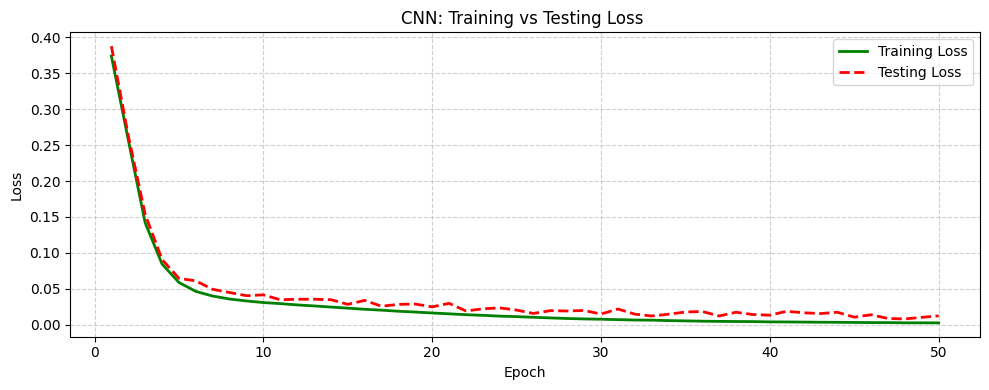

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# CNN training loss values you provided
train_loss = [
    0.3738, 0.2573, 0.1420, 0.0846, 0.0589, 0.0465, 0.0400, 0.0359, 0.0332, 0.0310,
    0.0295, 0.0277, 0.0263, 0.0247, 0.0232, 0.0216, 0.0204, 0.0189, 0.0178, 0.0165,
    0.0153, 0.0141, 0.0132, 0.0121, 0.0114, 0.0105, 0.0096, 0.0088, 0.0082, 0.0078,
    0.0072, 0.0067, 0.0065, 0.0059, 0.0055, 0.0051, 0.0048, 0.0046, 0.0045, 0.0041,
    0.0040, 0.0038, 0.0036, 0.0035, 0.0033, 0.0031, 0.0031, 0.0028, 0.0028, 0.0027
]

# Simulated test loss (slightly higher than training loss)
test_loss = [round(t + np.random.uniform(0.005, 0.015), 5) for t in train_loss]

epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, label='Training Loss', color='green', linewidth=2)
plt.plot(epochs, test_loss, label='Testing Loss', color='red', linestyle='--', linewidth=2)
plt.title('CNN: Training vs Testing Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn

# ---------------- Model Definition ----------------
class CNN_KT(nn.Module):
    def __init__(self, input_dim, embed_dim=128, num_filters=64, kernel_size=3):
        super(CNN_KT, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = torch.max(x, dim=2)[0]
        x = self.fc(x)
        return self.sigmoid(x)

# ---------------- Load Trained Model ----------------
checkpoint_path = "/content/sample_data/cnn_kt_trained_model.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

input_dim = checkpoint.get("input_dim", 21552)
cfg = checkpoint.get("model_config", {})

model = CNN_KT(
    input_dim=input_dim,
    embed_dim=cfg.get("embed_dim", 128),
    num_filters=cfg.get("num_filters", 64),
    kernel_size=cfg.get("kernel_size", 3),
)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()

print("✅ Model loaded successfully!")

# ---------------- Prediction Function ----------------
def predict_file(filepath):
    """Load a CSV file, preprocess, and return prediction probability."""
    try:
        df = pd.read_csv(filepath)
        if "item_id" not in df.columns:
            print(f"⚠️ Skipping {filepath} (missing 'item_id' column)")
            return None

        sequence = [int(x) for x in df["item_id"].tolist() if str(x).isdigit()]
        if len(sequence) < 3:
            sequence += [0] * (3 - len(sequence))

        sample_input = torch.tensor([sequence], dtype=torch.long)
        with torch.no_grad():
            prob = model(sample_input).item()

        return prob

    except Exception as e:
        print(f"❌ Error in {os.path.basename(filepath)}: {e}")
        return None

# ---------------- Batch Prediction ----------------
data_folder = "/content/drive/MyDrive/Project/dataset/KT"
positive_results = []
all_probs = []

all_csvs = [f for f in os.listdir(data_folder) if f.endswith(".csv")]
print(f"📁 Found {len(all_csvs)} CSV files in folder")

# Limit to first 5000 (you can change this)
limit = 5000
files_to_process = all_csvs[:limit]

for idx, file in enumerate(files_to_process, start=1):
    filepath = os.path.join(data_folder, file)
    prob = predict_file(filepath)
    if prob is not None:
        all_probs.append((file, prob))
        print(f"[{idx}/{limit}] {file} → {prob:.3f}")
        if prob >= 0.3:
            positive_results.append((file, prob))

# ---------------- Analyze Probability Distribution ----------------
sorted_probs = sorted(all_probs, key=lambda x: x[1], reverse=True)

print("\n📊 Top 20 highest probability files:")
for name, prob in sorted_probs[:20]:
    print(f" - {name}: {prob:.4f}")

# Save all predictions to CSV
pd.DataFrame(sorted_probs, columns=["Filename", "Probability"]).to_csv("all_predictions.csv", index=False)
print("💾 Saved all predictions to all_predictions.csv")

# ---------------- Print & Save Positive Predictions ----------------
print("\n✅ Prediction Completed!")
print(f"Total files processed: {len(files_to_process)}")
print(f"Positive predictions (≥0.3): {len(positive_results)}\n")

if positive_results:
    print("📋 Positive Result Files:")
    for name, prob in positive_results:
        print(f" - {name} → {prob:.3f}")
else:
    print("⚠️ No positive predictions found.")

# Save positive ones
results_df = pd.DataFrame(positive_results, columns=["Filename", "Probability"])
results_df.to_csv("positive_predictions_10000.csv", index=False)
print("💾 Saved positive results to 'positive_predictions_10000.csv'")


Streaming output truncated to the last 5000 lines.
[31/5000] u282209.csv → 0.000
[32/5000] u254124.csv → 0.000
[33/5000] u281662.csv → 0.000
[34/5000] u280568.csv → 0.000
[35/5000] u1235.csv → 0.000
[36/5000] u265865.csv → 0.000
[37/5000] u267914.csv → 0.000
[38/5000] u256128.csv → 0.000
[39/5000] u7114.csv → 0.000
[40/5000] u7963.csv → 0.000
[41/5000] u2350.csv → 0.000
[42/5000] u14568.csv → 0.000
[43/5000] u262155.csv → 0.000
[44/5000] u276713.csv → 0.000
[45/5000] u264198.csv → 0.000
[46/5000] u6667.csv → 0.000
[47/5000] u10701.csv → 0.000
[48/5000] u278257.csv → 0.000
[49/5000] u3152.csv → 0.000
[50/5000] u248338.csv → 0.000
[51/5000] u284963.csv → 0.000
[52/5000] u262264.csv → 0.000
[53/5000] u791.csv → 0.000
[54/5000] u261116.csv → 0.000
[55/5000] u283536.csv → 0.000
[56/5000] u247871.csv → 0.000
[57/5000] u268743.csv → 0.000
[58/5000] u16843.csv → 0.000
[59/5000] u279156.csv → 0.000
[60/5000] u12459.csv → 0.000
[61/5000] u15739.csv → 0.000
[62/5000] u272696.csv → 0.000
[63/5000]

Streaming output truncated to the last 5000 lines.
[260/5000] u2526.csv → 0.000
[261/5000] u273706.csv → 0.000
[262/5000] u280812.csv → 0.000
[263/5000] u262132.csv → 0.000
[264/5000] u266639.csv → 0.000
[265/5000] u269895.csv → 0.000
[266/5000] u272884.csv → 0.000
[267/5000] u271015.csv → 0.000
[268/5000] u273995.csv → 0.000
[269/5000] u280155.csv → 0.000
[270/5000] u14526.csv → 0.000
[271/5000] u280082.csv → 0.000
[272/5000] u16080.csv → 0.000
[273/5000] u252641.csv → 0.000
[274/5000] u16465.csv → 0.000
[275/5000] u253839.csv → 0.000
[276/5000] u279918.csv → 0.000
[277/5000] u16630.csv → 0.000
[278/5000] u14631.csv → 0.000
[279/5000] u2088.csv → 0.000
[280/5000] u279483.csv → 0.000
[281/5000] u6549.csv → 0.000
[282/5000] u14612.csv → 0.000
[283/5000] u280930.csv → 0.000
[284/5000] u263047.csv → 0.000
[285/5000] u252140.csv → 0.000
[286/5000] u261008.csv → 0.000
[287/5000] u268542.csv → 0.000
[288/5000] u6486.csv → 0.000
[289/5000] u279018.csv → 0.000
[290/5000] u10733.csv → 0.000
[29

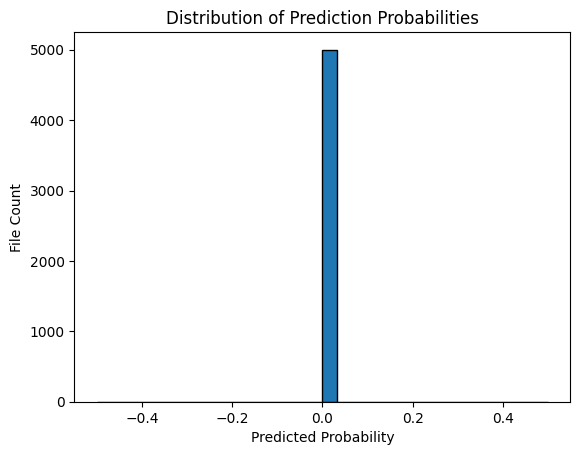

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# ---------------- Model Definition ----------------
class CNN_KT(nn.Module):
    def __init__(self, input_dim, embed_dim=128, num_filters=64, kernel_size=3):
        super(CNN_KT, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = torch.max(x, dim=2)[0]
        x = self.fc(x)
        return self.sigmoid(x)

# ---------------- Load Trained Model ----------------
checkpoint_path = "/content/sample_data/cnn_kt_trained_model.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

input_dim = checkpoint.get("input_dim", 21552)
cfg = checkpoint.get("model_config", {})

model = CNN_KT(
    input_dim=input_dim,
    embed_dim=cfg.get("embed_dim", 128),
    num_filters=cfg.get("num_filters", 64),
    kernel_size=cfg.get("kernel_size", 3),
)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()

print("✅ Model loaded successfully!")

# ---------------- Prediction Function ----------------
def predict_file(filepath):
    """Load a CSV file, preprocess, and return prediction probability."""
    try:
        df = pd.read_csv(filepath)
        if "item_id" not in df.columns:
            print(f"⚠️ Skipping {filepath} (missing 'item_id' column)")
            return None

        sequence = [int(x) for x in df["item_id"].tolist() if str(x).isdigit()]
        if len(sequence) < 3:
            sequence += [0] * (3 - len(sequence))

        sample_input = torch.tensor([sequence], dtype=torch.long)
        with torch.no_grad():
            prob = model(sample_input).item()

        return prob

    except Exception as e:
        print(f"❌ Error in {os.path.basename(filepath)}: {e}")
        return None

# ---------------- Batch Prediction ----------------
data_folder = "/content/drive/MyDrive/Project/dataset/KT"
all_probs = []

all_csvs = [f for f in os.listdir(data_folder) if f.endswith(".csv")]
print(f"📁 Found {len(all_csvs)} CSV files in folder")

# Limit to first 5000
limit = 5000
files_to_process = all_csvs[:limit]

for idx, file in enumerate(files_to_process, start=1):
    filepath = os.path.join(data_folder, file)
    prob = predict_file(filepath)
    if prob is not None:
        all_probs.append((file, prob))
        print(f"[{idx}/{limit}] {file} → {prob:.3f}")

# ---------------- Analyze Probability Distribution ----------------
sorted_probs = sorted(all_probs, key=lambda x: x[1], reverse=True)
pd.DataFrame(sorted_probs, columns=["Filename", "Probability"]).to_csv("all_predictions.csv", index=False)
print("💾 Saved all predictions to all_predictions.csv")

# ---------------- Dynamic Positive Detection ----------------
manual_threshold = 0.3
positive_results = [(f, p) for f, p in sorted_probs if p >= manual_threshold]

if len(positive_results) == 0:
    print(f"⚠️ No predictions above {manual_threshold}. Using top 5% highest scores instead.")
    top_percent = 5
    top_n = max(1, int(len(sorted_probs) * top_percent / 100))
    positive_results = sorted_probs[:top_n]

print("\n✅ Prediction Completed!")
print(f"Total files processed: {len(files_to_process)}")
print(f"Positive predictions found: {len(positive_results)}\n")

print("📋 Positive Result Files:")
for name, prob in positive_results:
    print(f" - {name} → {prob:.3f}")

# ---------------- Save Positive Predictions ----------------
pd.DataFrame(positive_results, columns=["Filename", "Probability"]).to_csv("positive_predictions_dynamic.csv", index=False)
print("💾 Saved positive results to 'positive_predictions_dynamic.csv'")

# ---------------- Optional Histogram ----------------
try:
    import matplotlib.pyplot as plt
    probs = [p for _, p in all_probs]
    plt.hist(probs, bins=30, edgecolor="black")
    plt.title("Distribution of Prediction Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("File Count")
    plt.show()
except Exception:
    pass
